In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv


# **Text Processing and Prediction**
## **Table of Content**
1. A support vector machine (SVM) model using text features extracted from text. 
2. A classification model as in the previous point, but features applying stop word processing to filter out common words.  
3. Fine-tuning an existing embedding model with FastText

# **Install prerequisite packages**

In [2]:
#!python3 -m nltk.downloader wordnet
#!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

In [3]:
import tensorflow as tf
import seaborn as sns #For visualization
import matplotlib.pyplot as plt
import textblob
#from textblob import TextBlob # For preprocessing text
#from textblob import Word
#from nltk.stem import WordNetLemmatizer

# **Loading dataset**
First we load dataset from Kaggle using pandas `DataFrame`. We will use three pre-splited datasets for modelling:

* **Training set:** A subset of the main dataset will feed into the model so that that model can learn the data patterns.
* **Validation Set:** This set is used to understand the performance of the model in comparison to different models and hyperparameter choices.
* **Test set:** This set checks the final model’s accuracy.

In [4]:
def load_labeled_review_dataset(file_name):
    """ Here we load labeled review datasets"""
    
    # Path where csv file are located
    base_path = "../input/imdb-dataset-sentiment-analysis-in-csv-format/" + file_name
    
    # Get train, validation,and test datasets
    df = pd.read_csv(base_path)
    # Return a copy of that data
    
    return df
# Save the three dataset into 3 variables
data_train = load_labeled_review_dataset('Train.csv')
data_val = load_labeled_review_dataset('Valid.csv')
data_test = load_labeled_review_dataset('Test.csv')

print(f'There are {data_train.shape[0]} comments for training.')
print(f'There are {data_val.shape[0]} comments for validation.')
print(f'There are {data_test.shape[0]} comments for testing.')

There are 40000 comments for training.
There are 5000 comments for validation.
There are 5000 comments for testing.


In [5]:
# Print the first 10 rows of data
data_train.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [6]:
data_test.head(10)

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
5,"I saw this film on September 1st, 2005 in Indi...",1
6,I saw a screening of this movie last night. I ...,0
7,William Hurt may not be an American matinee id...,1
8,IT IS A PIECE OF CRAP! not funny at all. durin...,0
9,I'M BOUT IT(1997)<br /><br />Developed & publi...,0


In [7]:
data_val.head(10)

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0
5,This is the best movie I've ever seen! <br /><...,1
6,The morbid Catholic writer Gerard Reve (Jeroen...,1
7,"""Semana Santa"" or ""Angel Of Death"" is a very w...",0
8,Somebody mastered the difficult task of mergin...,1
9,Why did I waste 1.5 hours of my life watching ...,0


# **Data Preprocessing**
##  **1. Checking for imbalance**

Before moving forward to modelling, it is best to assume that the data we are working on is imbalance. This means that the dataset doesn't contain a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class in train data:

label
0    20019
1    19981
Name: count, dtype: int64

Value count for each class in validation data:

label
1    2514
0    2486
Name: count, dtype: int64

Value count for each class in test data:

label
1    2505
0    2495
Name: count, dtype: int64



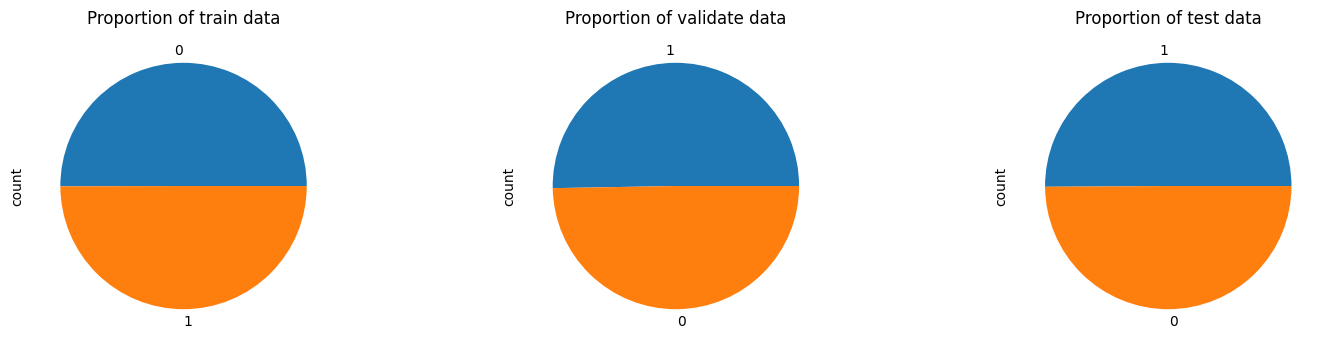

In [8]:
# Print actual value count for data_train
print(f"Value counts for each class in train data:\n\n{data_train.label.value_counts()}\n");
print(f"Value count for each class in validation data:\n\n{data_val.label.value_counts()}\n");
print(f"Value count for each class in test data:\n\n{data_test.label.value_counts()}\n");

# Display pie chart to visually check the proportion
plt.figure(figsize=[18, 4])

# Display train portions
plt.subplot(131);
train_chart= data_train.label.value_counts().plot.pie(y='label', title='Proportion of train data');

# Display validate portions
plt.subplot(132);
val_chart = data_val.label.value_counts().plot.pie(y='label', title='Proportion of validate data');

# Display test portions
plt.subplot(133);
test_chart = data_test.label.value_counts().plot.pie(y='label', title='Proportion of test data');

## **2. Text Cleaning**
Based on the display of the data, the text contains many noisy variables. Therefore, we need to clean up the datasets before moving to feature engineering. We create a functions that conduct the following steps:
* Lemmatization - the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.

In [9]:
def preprocessing_fn(dataframe):
    # convert uppercase to lowercase character
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # remove punctuation
    dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
    
    # remove html syntax
    dataframe['text'] = dataframe['text'].str.replace('<br />',' ')
    
    # remove numbers
    #dataframe['text'] = dataframe['text'].str.replace('\d','')
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    # delete rare character
    sil = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-1000:]
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))
    
    # Lemmatization with TextBlob
    #dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return dataframe

Let's see how the cleaned data look like

In [10]:
data_train.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [11]:
# Train dataset
cleaned_dt_train = preprocessing_fn(data_train)
cleaned_dt_train.head(10)

,text,label
0,i grew up (b. 1965) watching and loving the th...,0
1,"when i put this movie in my dvd player, and sa...",0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1
5,a terrible movie as everyone has said. what ma...,0
6,finally watched this shocking movie last night...,1
7,i caught this film on azn on cable. it sounded...,0
8,it may be the remake of autumn's tale after el...,1
9,my super ex girlfriend turned out to be a plea...,1


In [12]:
# Validation dataset
cleaned_dt_val = preprocessing_fn(data_val)
cleaned_dt_val.head(10)

,text,label
0,it's been about years since sharon stone award...,0
1,someone needed to make a car payment... this i...,0
2,the guidelines state that a comment must conta...,0
3,this movie is a muddled mish-mash of clichés f...,0
4,before stan laurel became the smaller half of ...,0
5,this is the best movie i've ever seen! maybe i...,1
6,the morbid catholic writer gerard reve (jeroen...,1
7,"""semana santa"" or ""angel of death"" is a very w...",0
8,somebody mastered the difficult task of mergin...,1
9,why did i waste 1.5 hours of my life watching ...,0


In [49]:
# Test dataset
cleaned_dt_test = preprocessing_fn(data_test)
cleaned_dt_test.head(10)

,text,label
0,always wrote series complete stink-fest jim be...,0
1,1st watched 12/7/2002 - 10(dir-steve purcell):...,0
2,movie poorly written directed fell asleep minu...,0
3,interesting thing miryang (secret sunshine) ac...,1
4,"first read ""berlin meer"" expect much. thought ...",0
5,"saw film september 1st, indianapolis. one judg...",1
6,saw screening movie last night. high expectati...,0
7,william hurt may american matinee idol anymore...,1
8,piece crap! funny all. whole movie nothing eve...,0
9,i'm bout it(1997) developed & published limit ...,0


## **2. Data splitting** 
Splitting train and output variables

In [14]:
# Split train dataset
X_train = cleaned_dt_train['text']
y_train = cleaned_dt_train['label']

# Split validation dataset
X_valid = cleaned_dt_val['text']
y_valid = cleaned_dt_val['label']

# Split test dataset
X_test = cleaned_dt_test['text']
y_test = cleaned_dt_test["label"]

X_train.head()

0    i grew up (b. 1965) watching and loving the th...
1    when i put this movie in my dvd player, and sa...
2    why do people who do not know what a particula...
3    even though i have great interest in biblical ...
4    im a die hard dads army fan and nothing will e...
Name: text, dtype: object

# **1. A support vector machine (SVM) model**

# **Feature Engineering**
## **1. Data Labeling**
### 1.1 Establishing performance lower and upper bounds for reference
To properly compare different training strategies we need to establish a baseline for model accuracy, in this case you will establish both a lower and an upper bound to compare against.

Calculate accuracy of a labeling strategy
[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in the sklearn ecosystem to encode text based data.

***ngram_rangetuple (min_n, max_n), default=(1, 1)***
*The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.*

After counting CountVectorizer, we might also face an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies. So we will use [TfidTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

### 2. Training Models
For training model, I decided to choose[Suppor t Vector Machine (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier), which is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes):

I want to choose a traditional model first as it should be sufficient to for this dataset and I don't want to overkill with deep learning models like deep neural network. We can change the hyperparameter and learner in SVM by simply plugging a different classifier object into our pipeline

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# Setting up hyperparameters
sdg_params1 = dict(alpha=1e-5, penalty='l2', loss='log_loss') # Set logistic regression and learning rate
vectorizer_params1 = dict(ngram_range=(1, 5)) # Allow unigrams and bigrams

# Setting up hyperparameters
sdg_params2 = dict(alpha=1e-5, penalty='l2', loss='log_loss') # Set logistic regression and learning rate
vectorizer_params2 = dict(ngram_range=(1, 2), min_df=5, max_df=0.8) # Allow unigrams and bigrams


# Supervise Learning - Logistic Regression
pipeline1 = Pipeline(
    [
        ("vect", CountVectorizer(**vectorizer_params1)),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier(**sdg_params1)),
    ]
)

# Supervise Learning - Logistic Regression
pipeline2 = Pipeline(
    [
        ("vect", CountVectorizer(**vectorizer_params2)),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier(**sdg_params2)),
    ]
)

def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:", sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(
        "Micro-averaged F1 score: %0.3f"
        % f1_score(y_test, y_pred, average="micro")
    )
    print(
        "Acuracy score: %0.3f"
        % accuracy_score(y_test, y_pred)
    )
    print(
        "Precision score: %0.3f"
        % precision_score(y_test, y_pred, average="micro")
    )
    print(
        "Recall score: %0.3f"
        % recall_score(y_test, y_pred, average="micro")
    )
    print("-" * 10)
    print("")
    print()
    

In [57]:
print("Supervised SGDClassifier on 100% of the data hyperparameter 1:")
eval_and_print_metrics(pipeline1, X_train, y_train, X_valid, y_valid)

print("Supervised SGDClassifier on 100% of the data hyperparameter 2:")
eval_and_print_metrics(pipeline2, X_train, y_train, X_valid, y_valid)

Supervised SGDClassifier on 100% of the data hyperparameter 1:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.887
Acuracy score: 0.887
Precision score: 0.887
Recall score: 0.887
----------


Supervised SGDClassifier on 100% of the data hyperparameter 2:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.905
Acuracy score: 0.905
Precision score: 0.905
Recall score: 0.905
----------




Now let's test pipeline 2 again!

In [58]:
print("Testing pipeline 2 with test set:")
eval_and_print_metrics(pipeline2, X_train, y_train, X_test, y_test)

Testing pipeline 2 with test set:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.913
Acuracy score: 0.913
Precision score: 0.913
Recall score: 0.913
----------




# **Data Preprocessing with StopWord Text Cleaning**


In [18]:
#stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [19]:
def preprocessing_fn_sw(dataframe):
    # convert uppercase to lowercase character
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # remove punctuation
    dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
    
    # remove html syntax
    dataframe['text'] = dataframe['text'].str.replace('<br />',' ')
    
    # remove numbers
    #dataframe['text'] = dataframe['text'].str.replace('\d','')
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    # delete rare character
    sil = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-1000:]
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))
    
    # use stopwords
    sw = stopwords.words('english')
    dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

    
    return dataframe

In [20]:
# Train dataset
cleaned_dt_train2 = preprocessing_fn_sw(data_train)
cleaned_dt_train2.head(10)

,text,label
0,grew (b. 1965) watching loving thunderbirds. m...,0
1,"put movie dvd player, sat coke chips, expectat...",0
2,people know particular time past like feel nee...,0
3,"even though great interest biblical movies, bo...",0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said. made laugh cameo...,0
6,"finally watched shocking movie last night, dis...",1
7,caught film azn cable. sounded like would good...,0
8,"may remake autumn's tale eleven years, directo...",1
9,super ex girlfriend turned pleasant surprise m...,1


In [21]:
# Validation dataset
cleaned_dt_val2 = preprocessing_fn_sw(data_val)
cleaned_dt_val2.head(10)

,text,label
0,years since sharon stone awarded viewers leg-c...,0
1,someone needed make car payment... truly awful...,0
2,guidelines state comment must contain minimum ...,0
3,movie muddled mish-mash clichés recent cinema....,0
4,stan laurel became smaller half all-time great...,0
5,best movie i've ever seen! maybe live miles vi...,1
6,morbid catholic writer gerard reve (jeroen kra...,1
7,"""semana santa"" ""angel death"" weak movie. mira ...",0
8,somebody mastered difficult task merging sport...,1
9,waste 1.5 hours life watching this? film even ...,0


In [22]:
# Test dataset
cleaned_dt_test2 = preprocessing_fn_sw(data_test)
cleaned_dt_test2.head(10)

,text,label
0,always wrote series complete stink-fest jim be...,0
1,1st watched 12/7/2002 - 10(dir-steve purcell):...,0
2,movie poorly written directed fell asleep minu...,0
3,interesting thing miryang (secret sunshine) ac...,1
4,"first read ""berlin meer"" expect much. thought ...",0
5,"saw film september 1st, indianapolis. one judg...",1
6,saw screening movie last night. high expectati...,0
7,william hurt may american matinee idol anymore...,1
8,piece crap! funny all. whole movie nothing eve...,0
9,i'm bout it(1997) developed & published limit ...,0


In [23]:
# Split train dataset
X_train2 = cleaned_dt_train2['text']
y_train2 = cleaned_dt_train2['label']

# Split validation dataset
X_valid2 = cleaned_dt_val2['text']
y_valid2 = cleaned_dt_val2['label']

# Split test dataset
X_test2 = cleaned_dt_test2['text']
y_test2 = cleaned_dt_test2["label"]

X_train2.head()

0    grew (b. 1965) watching loving thunderbirds. m...
1    put movie dvd player, sat coke chips, expectat...
2    people know particular time past like feel nee...
3    even though great interest biblical movies, bo...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

In [59]:
print("Supervised SGDClassifier with StopWord on 100% of the data hyperparameter 1:")
eval_and_print_metrics(pipeline1, X_train2, y_train2, X_valid2, y_valid2)

print("Supervised SGDClassifier with StopWord on 100% of the data hyperparameter 2:")
eval_and_print_metrics(pipeline2, X_train2, y_train2, X_valid2, y_valid2)

Supervised SGDClassifier with StopWord on 100% of the data hyperparameter 1:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.881
Acuracy score: 0.881
Precision score: 0.881
Recall score: 0.881
----------


Supervised SGDClassifier with StopWord on 100% of the data hyperparameter 2:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.901
Acuracy score: 0.901
Precision score: 0.901
Recall score: 0.901
----------




In [60]:
print("Testing pipeline 2 with test set and StopWord:")
eval_and_print_metrics(pipeline2, X_train2, y_train2, X_test2, y_test2)

Testing pipeline 2 with test set and StopWord:
Number of training samples: 40000
Unlabeled samples in training set: 0
Micro-averaged F1 score: 0.905
Acuracy score: 0.905
Precision score: 0.905
Recall score: 0.905
----------




We can see using stopword decrease acuracy of the model, this is a know issue when filtering English words. It can be further explained [here](https://scikit-learn.org/stable/modules/feature_extraction.html#using-stop-words). 
One alternative would be setting `max_df` to a higher value, such as in the range (0.7, 1.0), can automatically detect and filter stop words based on intra corpus document frequency of terms.
Or you can create your own stop words set for different purposes.

[Source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

# **3. Fine-tuning FastText**
## **Installing fastText package**
The first step is to install and build fastText. It only requires a c++ compiler with good support of c++11.

Let us start by downloading the most [recent release](https://github.com/facebookresearch/fastText/releases):

In [26]:
!wget https://github.com/facebookresearch/fastText/archive/refs/tags/v0.9.2.zip

--2024-02-10 01:13:00--  https://github.com/facebookresearch/fastText/archive/refs/tags/v0.9.2.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2 [following]
--2024-02-10 01:13:00--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'v0.9.2.zip'

v0.9.2.zip              [  <=>               ]   4.17M  19.7MB/s    in 0.2s    

2024-02-10 01:13:00 (19.7 MB/s) - 'v0.9.2.zip' saved [4369852]



In [27]:
!unzip v0.9.2.zip

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fastText-0.9.2/.circleci/cmake_test.sh  
  inflating: fastText-0.9.2/.circleci/config.yml  
  inflating: fastText-0.9.2/.circleci/gcc_test.sh  
  inflating: fastText-0.9.2/.circleci/pip_test.sh  
  inflating: fastText-0.9.2/.circleci/pull_data.sh  
  inflating: fastText-0.9.2/.circleci/python_test.sh  
  inflating: fastText-0.9.2/.circleci/run_locally.sh  
  inflating: fastText-0.9.2/.circleci/setup_circleimg.sh  
  inflating: fastText-0.9.2/.circleci/setup_debian.sh  
  inflating: fastText-0.9.2/.gitignore  
  inflating: fastText-0.9.2/CMakeLists.txt  
  inflating: fastText-0.9.2/CODE_OF_CONDUCT.md  
  inflating: fastText-0.9.2/CONTRIBUTING.md  
  inflating: fastText-0.9.2/LICENSE  
  inflating: fastText-0.9.2/MANIFEST.in  
  inflating: fastText-0.9.2/Makefile  
  inflating: fastText-0.9.2/README.md  
   creating: fastText-0.9.2/alignment/
  in

Move to the fastText directory and build it:

In [28]:
! cd fastText-0.9.2 && pip install .

Processing /kaggle/working/fastText-0.9.2
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=318738 sha256=ed0986b25b141a5475e88d29f7d0e048a1dee6727b8021aebbb53aba08143b55
  Stored in directory: /root/.cache/pip/wheels/03/53/52/d2686028e1e5e5bd554aee5912cb6af83155c102521225f2a6
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


## **Retraining the model**

### **Preprocessing the data**
By default, fastText will read each line of the text file `.txt` contains a list of **labels**, followed by the corresponding document. All the labels start by the `__label__` prefix, which is how fastText recognize what is a label or what is a word. The model is then trained to predict the labels given the word in the document. Therefore, we need to transform our preprocess data the format that fastText can use.

In [47]:
# Recheck our preprocessed data
cleaned_dt_train.head(10)

,text,label
0,grew (b. 1965) watching loving thunderbirds. m...,0
1,"put movie dvd player, sat coke chips, expectat...",0
2,people know particular time past like feel nee...,0
3,"even though great interest biblical movies, bo...",0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said. made laugh cameo...,0
6,"finally watched shocking movie last night, dis...",1
7,caught film azn cable. sounded like would good...,0
8,"may remake autumn's tale eleven years, directo...",1
9,super ex girlfriend turned pleasant surprise m...,1


Now we need add new label column to the data

In [30]:
# Add __label__ data to new label column
def add_label_column(data):
    # create a new data file
    new_data = data.copy()
    
    # Create a new column
    label_train = pd.Series([]) 
    
    # fill each row with '__label__' value
    for i in range(len(data)):
        if data["label"][i] == 1: 
            label_train[i] = "__label__positive"
        else:
            label_train[i] = "__label__negative"
    # inserting new column with new label value infront of 'text' column       
    new_data.insert(0, "new label", label_train)
    
    return new_data

Now we can drop the old label column

In [31]:
new_train = add_label_column(cleaned_dt_train)
new_train.drop('label',axis=1, inplace=True)
# drop the index columns 
# new_train.reset_index(drop=True, inplace=True) 
new_train.head(10)

,new label,text
0,__label__negative,grew (b. 1965) watching loving thunderbirds. m...
1,__label__negative,"put movie dvd player, sat coke chips, expectat..."
2,__label__negative,people know particular time past like feel nee...
3,__label__negative,"even though great interest biblical movies, bo..."
4,__label__positive,im die hard dads army fan nothing ever change ...
5,__label__negative,terrible movie everyone said. made laugh cameo...
6,__label__positive,"finally watched shocking movie last night, dis..."
7,__label__negative,caught film azn cable. sounded like would good...
8,__label__positive,"may remake autumn's tale eleven years, directo..."
9,__label__positive,super ex girlfriend turned pleasant surprise m...


In [32]:
new_valid = add_label_column(cleaned_dt_val)
new_valid.drop('label',axis=1, inplace=True)
new_valid.head(10)

,new label,text
0,__label__negative,years since sharon stone awarded viewers leg-c...
1,__label__negative,someone needed make car payment... truly awful...
2,__label__negative,guidelines state comment must contain minimum ...
3,__label__negative,movie muddled mish-mash clichés recent cinema....
4,__label__negative,stan laurel became smaller half all-time great...
5,__label__positive,best movie i've ever seen! maybe live miles vi...
6,__label__positive,morbid catholic writer gerard reve (jeroen kra...
7,__label__negative,"""semana santa"" ""angel death"" weak movie. mira ..."
8,__label__positive,somebody mastered difficult task merging sport...
9,__label__negative,waste 1.5 hours life watching this? film even ...


Now that the table have the correct label. We can transfer csv file to text file:
* Read the DataFrame file into a string.
* Write the content into the TXT file.
* Remove delimiter and double quote in text

In [34]:
def csv_to_txt(df, txt_file):
    # Save DataFrame as text file without header
    with open(txt_file, 'a') as f:
        # Avoid double quote " " in text value when it's converted to text file
        for row in df.itertuples(index=False):
            row_str = ' '.join(str(val).strip('"') for val in row)
            f.write(row_str + '\n')

In [35]:
# Uncommon this if you want to delete the output file to rerun the code
# ! rm 'text_train.txt'
# ! rm 'text_valid.txt'
# ! rm 'text_test.txt'

rm: cannot remove 'text_train.txt': No such file or directory
rm: cannot remove 'text_valid.txt': No such file or directory


In [36]:
# Convert the traning and test file
text_train = csv_to_txt(new_train, 'text_train.txt')
text_valid = csv_to_txt(new_train, 'text_valid.txt')

In [37]:
# Display sample text
def read_sample(file):
    file = open(file, "r")
    # print the first 20 lines
    content = file.readlines(20)
    print(content)
    file.close()
read_sample("text_train.txt")

['__label__negative grew (b. 1965) watching loving thunderbirds. mates school watched. played "thunderbirds" school, lunch school. wanted virgil scott. one wanted alan. counting became art form. took children see movie hoping would get glimpse loved child. bitterly disappointing. high point snappy theme tune. could compare original score thunderbirds. thankfully early saturday mornings one television channel still plays reruns series gerry anderson wife created. jonatha frakes hand directors chair, version completely hopeless. waste film. utter rubbish. cgi remake may acceptable replacing marionettes homo sapiens subsp. sapiens huge error judgment.\n']


## **Training: Text Classifier by Finetuning fastText**

In [38]:
import fasttext
# Fine-tuning the model
model = fasttext.train_supervised(input='text_train.txt', lr=0.75, wordNgrams=3, thread=8)


def print_results(N, p, r):
    print("N\t" + str(N))
    print("Precision at {}\t{:.3f}".format(1, p))
    print("Recall at {}\t{:.3f}".format(1, r))
    
# Test the model
print_results(*model.test('text_valid.txt'))

Read 5M words
Number of words:  316033
Number of labels: 2
Progress: 100.0% words/sec/thread:  270892 lr:  0.000000 avg.loss:  0.108765 ETA:   0h 0m 0s


N	40000
Precision at 1	1.000
Recall at 1	1.000


The output are the number of samples (here `40000`), the precision at one (1.000) and the recall at one (1.000).

In [39]:
# Uncommon this line to remove old model if you need to retrain
#! rm 'model_sentimal.bin'

In [40]:
# Now let's try saving the model
model.save_model("model_sentimal.bin")

## **Testing the model**

In [43]:
# Loading the train model
model = fasttext.load_model('model_sentimal.bin')

model.predict("This isn't just a beautifully crafted gangster film. Or an outstanding family portrait, for that matter. An amazing period piece. A character study. A lesson in filmmaking and an inspiration to generations of actors, directors, screenwriters and producers. For me, this is more: this is the definitive film. 10 stars out of 10.")


(('__label__positive',), array([0.99957663]))

In [44]:
model.predict("It's hard to overstate how bad this is. A stellar comedic cast and any one of them could have created a better movie if it was just 90 minutes of them reading the phone book.")

(('__label__negative',), array([0.99986827]))